Adding stored data to store the trades for calculation of results

In [ ]:
# Changes from 8:
# Almost similar to notebook 8, but for multiple instruments
# The adding of dictionaries, so that the data for all stocks can be stored
# Added one more func to stop trading when total capital  < 0. Previous model doesnt takes that into account.

In [2]:
# Install all important libraries
!pip install yfinance
!pip install ta


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# NSE list Dont run
list = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS" , "BAJAJ-AUTO.NS", "GRASIM.NS","ONGC.NS", "TITAN.NS" , "SHREECEM.NS" ,\
        "NESTLEIND.NS", "GAIL.NS", "CIPLA.NS", "BHARTIARTL.NS" ,"NTPC.NS", "TATASTEEL.NS", "COALINDIA.NS", "BAJFINANCE.NS", "ICICIBANK.NS",\
       "BAJAJFINSV.NS", "WIPRO.NS", "HINDALCO.NS" , "HDFCLIFE.NS", "MARUTI.NS", "RELIANCE.NS", "TCS.NS", "LT.NS", "INDUSINDBK.NS", "ITC.NS" , "TECHM.NS"]

In [ ]:
# SGX list Dont run
list = ["C52.SI", "T39.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI",\
        "D01.SI", "O39.SI", "S63.SI", "A17U.SI" , "BN4.SI","BS6.SI", "M44U.SI", "C31.SI", "H78.SI", \
        "Y92.SI", "C38U.SI", "U14.SI", "N2IU.SI" , "F34.SI" , "C09.SI" , "J36.SI", "S58.SI" , "C6L.SI", "J37.SI", "U96.SI" ,"1810.HK"]

In [3]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


In [ ]:
# For event based backtesting, an imporatant concept is a bar.
# A bar is unit of data or information. A bar represents an event.
# Event based Backtesting will be based on new bars coming at not on full dataset.

# First we will build a commonclass,
# this will be utilised for all the common purposes like preparing data, plotting results, placing orders etc

In [5]:
class Common_Class():

  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):

    #new dicts
    self.all_data ={}
    self.position = {} # position also a dict, commonenting out the self.position = 0
    self.quantity = {} # quantity also a dict. initialising with zero quantitties to all the shares
    for stock in symbol:
      self.quantity['{}'.format(stock)] = 0 #can also do at run strategy

    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.capital = capital # this capital will change depending on trades
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
    self.prepare_data() # prepares the data


  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    for i in self.symbol:
      stock_data = yf.Ticker(i)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data['{}'.format(i)] = bt_data

  def close_graph(self, stock):
    i = str(stock)
    plt.figure(figsize=(15, 5))
    plt.plot(self.all_data[i]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(i))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar, stock):
    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date
    i = str(stock)
    date = str(self.all_data[i].index[bar])[:10]
    price = self.all_data[i].Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):
    #Returns you the realised capital in your account at a given time period / bar
    date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, bar):
    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    #print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):
    #Unrealised plus realised
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    tb = ub + self.capital
    #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
    return tb

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  def performance_plots(self):

    Final_result_data = self.Final_result_data #saving time to write self everywhere
    interval = str(self.interval)
    f,ax = plt.subplots(2,3,figsize=(20,10))

    #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

    #f.tight_layout(h_pad=5, w_pad=2)

    #plot 1: Close Price os stock
    plt.subplot(2, 3, 1)
    for stock in self.symbol:
      plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
    plt.title("Cum Log returns of included stocks")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 2: Histogram of dtrstegy returns
    plt.subplot(2, 3, 2)
    plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
    plt.title("Histogram of Strategy returns")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 3: Strategy vs Instrument
    plt.subplot(2, 3, 3)
    plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
    plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
    plt.title("Strategy Vs Stock Cum Return Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 4: Drawdown
    plt.subplot(2, 3, 4)
    plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
    plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
    plt.title("Drawdown")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 5: Equity Curve
    plt.subplot(2, 3,  5)
    plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
    plt.title("Equity Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    plt.suptitle("Performance Plots")
    f.delaxes(ax[1,2]) # to delete the last subplot

    plt.show()

  def performance(self):

    # stored data has  [trade, date, position, price, symbol, quantity, capital]
    #B = self.stored_data # this will have many rows ; n(number of instruments) times more
    #C = self.all_data # will need this to aggregate the returns from all stocks
    #B.index = range(B.shape[0]/len(self.symbol))

    #Since the stocks are stored not in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
    #stored data has many rows, we will aggregate day wise

    df = pd.DataFrame() # creating a new datframe to store aggregated values

    df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
    # agrregating by mean because the run is done in loop (for all stocks in a list of symbols),
    # so each stock "date" will have the same capital accounting for all stocks

    #df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

    trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time.
    trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

    #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()) # The returns are already log
      df['Returns_{}'.format(stock)] = A
    c= df.columns #fetch all the columns of datframe
    df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divvide by number of stocks. Equal weightage
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df.index = range(df.shape[0])

    #Preparing metrics to calculate performance
    #df['exit_date'] = df['date'].shift(-1)

    # Not needed as now alreadt fetching rturns
    #B['exit_price'] = B['price'].shift(-1)
    #B['price_log_returns'] = np.log(B['exit_price']/B['price'])
    #B['price_log_returns_cum_sum'] = B['price_log_returns'] .cumsum()

    df['capital_after_settlement'] = df['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    #Remember, you can change the returns on investment based on the capital you trade

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

    # for drawdown calculation
    df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
    df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
    # The maximum difference is refered as "Drawdown"

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    df = df.dropna()
    #print(df.head())

    '''
    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price',\
           'price_log_returns','price_log_returns_cum_sum','capital',\
          'capital_after_settlement', 'capital_regular_returns', 'capital_log_returns',\
           'capital_returns_log_cum_sum','Cum_Max','drawdown']
    B = B[cols]
    B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    '''

    #storing the results in Final_result data
    Final_result_data = df
    #Final_result_data.head()

    #Plot the equity curve
    #plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])
    #Final_result_data[['exit_date', 'capital_after_settlement']].dropna().plot(figsize =(15,6), title = "Equity /Capital Plot")

    print("=" *50)
    print("Performance Metrics")

    #Total Balance
    print("The total capital at end of strategy: {:0.1f}".format(self.capital))

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio: {:0.2f}".format(SR))

    #The strategy returns on investment in percent

    #Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    #Total_Log_ret
    #Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    #print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, Regular_ROI))

    # the above method will also produce same result

    returns = (self.capital - self.initial_capital) /self.initial_capital *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, returns))

    #Calculate Drawdown
    #Final_result_data[["capital_returns_log_cum_sum", "Cum_Max"]].dropna().plot(figsize =(15,6), title = "Drawdown Plot")

    Drawdown = Final_result_data["drawdown"].max()*100
    print("The maximum drawdown: {:.2f} %".format(Drawdown))

    zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
    delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
    print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))

    #Annual Sortino Ratio
    only_neg_log_returns = Final_result_data[Final_result_data['capital_log_returns']<0]['capital_log_returns']
    only_neg_regular_returns = np.exp(only_neg_log_returns)-1

    daily_std_dev_for_sortino = only_neg_regular_returns.std()
    annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

    sortino = annual_regular_return / annual_std_dev_for_sortino
    print("The annual Sortino Ratio: {:0.2f}".format(sortino))

    #Total trades
    print("The total trades taken by the strategy: {}".format(self.trades))


    print("=" *50)

    self.Final_result_data = Final_result_data
    #print(self.Final_result_data.head())


  def buy_order(self,bar,stock,quantity=None, dollar =None ):
    date, price = self.return_date_price(bar,stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = 1
    tb = self.total_balance(bar)
    #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)


  def sell_order(self,bar,stock, quantity=None, dollar=None ):
    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = -1
    tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)

  def last_trade(self, bar):# this needs to be check for all open positions of all stocks

    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.quantity['{}'.format(stock)]
      self.capital = self.capital + last_quantity * price
      self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
      self.trades = self.trades +1
      if self.position['{}'.format(stock)] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
        self.position['{}'.format(stock)] = 1 # to record we are buying to close out
      else:
        last_quantity =  last_quantity # to keep a positve nymber in records
        self.position['{}'.format(stock)] = -1 # to record we are selling to close out
      #self.position = 0
      tb = self.total_balance(bar)
      self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

      if self.verbose:
        print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))
        #print("--------------Final Balance-----------")
        #self.total_balance(bar)
        #returns = (self.capital - self.initial_capital) /self.initial_capital *100
        #print("------------------------------")
        #print("The total capital at end of strategy: {:0.1f}".format(self.capital))
        #print("The strategy returns on investment are {:0.1f} %".format(returns))
        #print("Total trades by startegy are {:0.1f}".format(self.trades))

    #print("=" *50)
    #print("--------------Final Balance-----------")
    #tb = self.total_balance(bar)
    #print("Total balan from tb is ", tb)
    #print('self.capital is ', self.capital)
    #returns = (self.capital - self.initial_capital) /self.initial_capital *100
    #print("The total capital at end of strategy: {:0.1f}".format(self.capital))
    #print("The strategy returns on investment are {:0.1f} %".format(returns))
    #print("Total trades by startegy are {:0.1f}".format(self.trades))
    #print("=" *50)


C:\Users\ryanl\AppData\Local\Temp\ipykernel_7444\1730464758.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data = pd.concat([self.stored_data, trade_detail])


Performance Metrics
The total capital at end of strategy: 12338.0
The annual regular returns: 138.20 %
The annual regular std deviation: 56.56 %
The annual Sharpe Ratio: 2.44
The returns on investment from 2020-01-01 to 2020-06-01 by this strategy is 23.4 %
The maximum drawdown: 18.46 %
The maximum drawdown period: 2.00 days
The annual Sortino Ratio: 4.51
The total trades taken by the strategy: 108


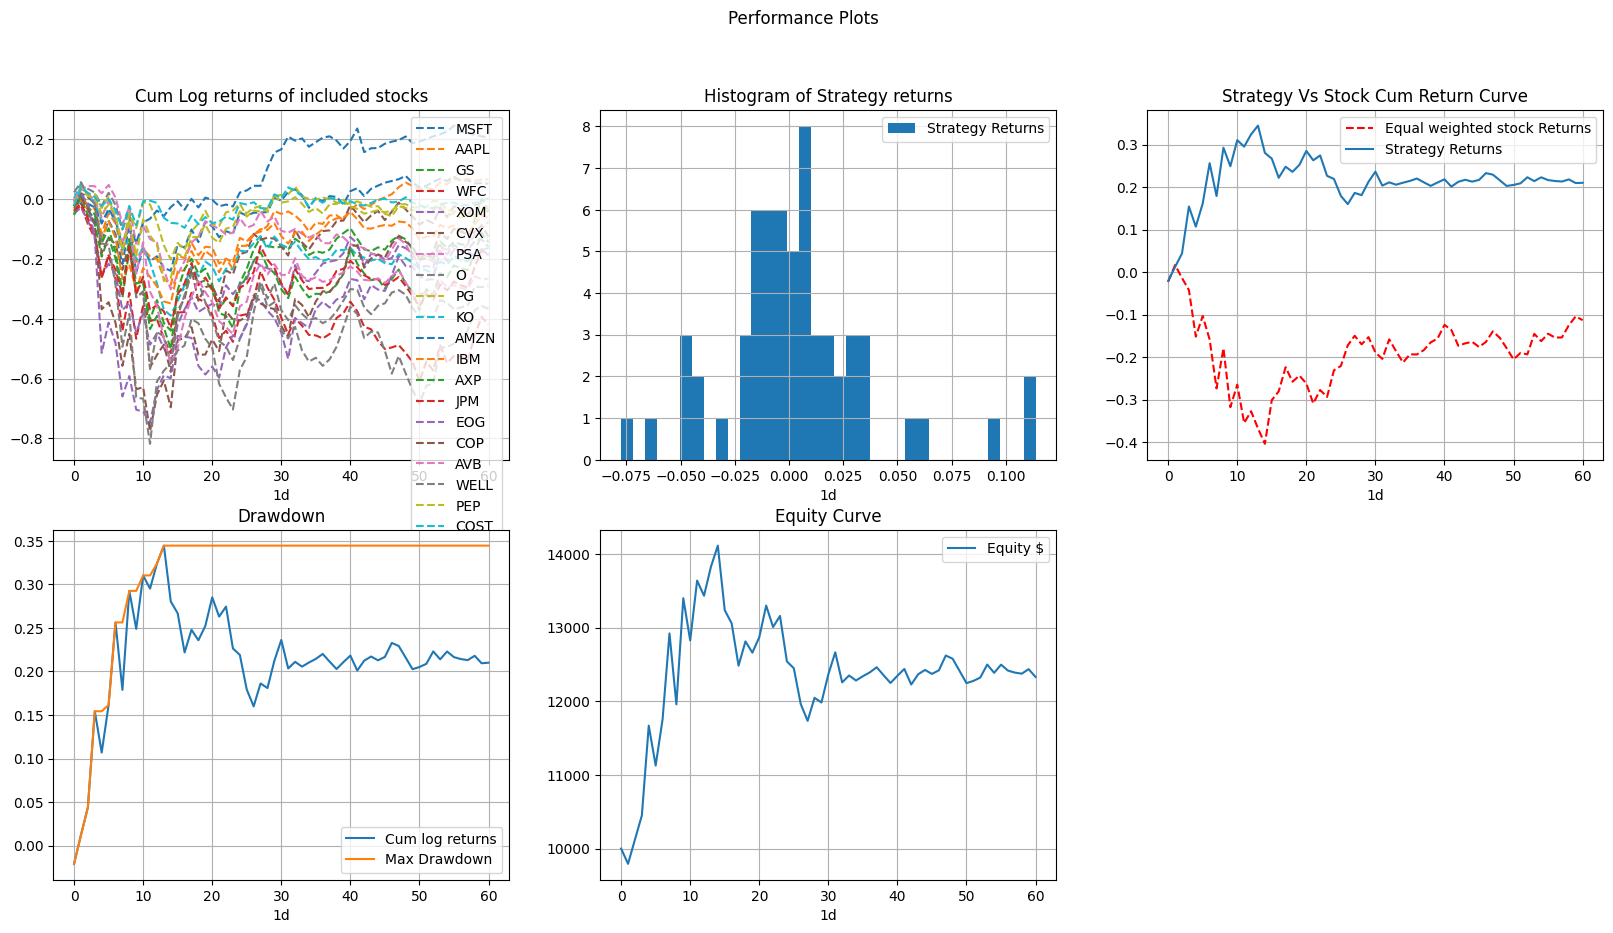

In [ ]:
class MA_Strategy(Common_Class):

  def go_long(self, bar, stock, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position['{}'.format(stock)] == -1:
      self.position['{}'.format(stock)] = 0
      self.buy_order(bar,stock, quantity = -self.quantity['{}'.format(stock)]) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.buy_order(bar, stock, dollar = dollar)


  def go_short(self, bar, stock, quantity = None, dollar = None):
    if self.position['{}'.format(stock)] == 1:
      self.position['{}'.format(stock)] = 0
      self.sell_order(bar,stock, quantity = self.quantity['{}'.format(stock)]) #to clear previous long vposition
    if quantity:
      self.sell_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.sell_order(bar, stock, dollar = dollar)

  def run_strategy(self, STMA_window, LTMA_window): # add the parameters according to the strategy
    self.stop = False
    self.trades = 0
    self.capital = self.initial_capital

    #Preparing data with LTMA and STMA so that can check crossovers. Also initialising with 0 quantity and 0 position

    for stock in self.symbol:
      self.quantity['{}'.format(stock)] = 0
      self.position['{}'.format(stock)] = 0

      indicator_1 = SMAIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window = STMA_window, fillna= False)
      STMA = indicator_1.sma_indicator()

      indicator_2 = SMAIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window = LTMA_window, fillna= False)
      LTMA = indicator_2.sma_indicator()

      self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)] = STMA
      self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)] = LTMA

    for bar in range(LTMA_window, len(self.all_data['{}'.format(self.symbol[0])])): # from the available data bar to the last data bar
      #Making a func so that no trade if balance goes below 0

      tb = self.total_balance(bar)
      if tb< 0:
        print("negative capital")
        self.last_trade(bar)
        self.stop = True
        break

      for stock in self.symbol:
        date, price = self.return_date_price(bar, stock)

        if self.position['{}'.format(stock)] in [0,-1]: # checking no position or short position
          if self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)].iloc[bar] > self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)].iloc[bar]:
             self.go_long(bar,stock, dollar = self.capital/len(self.symbol)) # go with equal money # Make sure to enter less than initila capital
             #print("--------")
             continue # as I am storing data for SR calculations. Dont wnat duplication

        if self.position['{}'.format(stock)] in [0,1]: # checking no position or long position
          if self.all_data['{}'.format(stock)]['STMA_{}'.format(stock)].iloc[bar] < self.all_data['{}'.format(stock)]['LTMA_{}'.format(stock)].iloc[bar]:
            self.go_short(bar,stock, dollar =self.capital/len(self.symbol)) # go with equal money
            #print("--------")
            continue

        #-----Storing all the values for calculating Sharpe-----
        store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)  # I have used continue in previous "if conditions", So if they didnt execute meaning no trade conditions that day ; trade = 0

    if self.stop == False: # to make sure not to run this func 2 times when early exit due to negative balance
      self.last_trade(bar)  # amke sure the crossover happens, give more time

if __name__ == "__main__":
    stocks = ['MSFT', 'AAPL', 'GS', 'WFC', 'XOM', 'CVX', 'PSA', 'O', 'PG', 'KO', 'AMZN', 'IBM', 'AXP', 'JPM','EOG','COP', 'AVB', 'WELL','PEP','COST']
    A = MA_Strategy(stocks, "2020-01-01", "2020-06-01","1d", 10000, 0.00, False)
    A.run_strategy(10,40)
    A.performance()
    A.performance_plots()

  #UnboundLocalError: local variable 'bar' referenced before assignment
  # If duration of test or difference between start date aand end date is less than MA


In [ ]:
from ta.volatility import BollingerBands

class BollingerBandStrategy(Common_Class):
    def __init__(self, symbol, start, end, interval, capital, transaction_cost, verbose=True, window=20, window_dev=2):
        super().__init__(symbol, start, end, interval, capital, transaction_cost, verbose)
        self.window = window
        self.window_dev = window_dev

        # Sector mapping
        self.sector_mapping = {
            'MSFT': 'Technology',
            'AAPL': 'Technology',
            'GS': 'Financials',
            'WFC': 'Financials',
            'XOM': 'Energy',
            'CVX': 'Energy',
            'PSA': 'Real Estate',
            'O': 'Real Estate',
            'PG': 'Consumer Staples',
            'KO': 'Consumer Staples',
            'AMZN': 'Consumer Discretionary',
            'IBM': 'Technology',
            'AXP': 'Financials',
            'JPM': 'Financials',
            'EOG': 'Energy',
            'COP': 'Energy',
            'AVB': 'Real Estate',
            'WELL': 'Real Estate',
            'PEP': 'Consumer Staples',
            'COST': 'Consumer Staples'
        }

        self.sector_etfs = {
            'Technology': 'XLK',
            'Financials': 'XLF',
            'Energy': 'XLE',
            'Real Estate': 'IYR',
            'Consumer Staples': 'XLP',
            'Consumer Discretionary': 'XLY'
        }

        self.stocks = [s for s in self.symbol if s not in self.sector_etfs.values()]
        # Initialize positions and quantities
        for stock in self.symbol:
            self.quantity[stock] = 0
            self.position[stock] = 0

    def go_long(self, bar, stock, quantity=None, dollar=None):
        if self.position[stock] == -1:
            self.position[stock] = 0
            self.buy_order(bar, stock, quantity=-self.quantity[stock])
        if quantity:
            self.buy_order(bar, stock, quantity=quantity)
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
            else:
                dollar = self.capital / len(self.stocks)
            self.buy_order(bar, stock, dollar=dollar)

    def go_short(self, bar, stock, quantity=None, dollar=None):
        if self.position[stock] == 1:
            self.position[stock] = 0
            self.sell_order(bar, stock, quantity=self.quantity[stock])
        if quantity:
            self.sell_order(bar, stock, quantity=quantity)
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
            else:
                dollar = self.capital / len(self.stocks)
            self.sell_order(bar, stock, dollar=dollar)

    def run_strategy(self):
        self.stop = False
        self.trades = 0
        self.capital = self.initial_capital

        # Compute Bollinger Bands for stocks
        for stock in self.stocks:
            indicator_bb = BollingerBands(
                close=self.all_data[stock]["Close_Price"],
                window=self.window,
                window_dev=self.window_dev
            )
            self.all_data[stock]['bb_middle_band'] = indicator_bb.bollinger_mavg()
            self.all_data[stock]['bb_upper_band'] = indicator_bb.bollinger_hband()
            self.all_data[stock]['bb_lower_band'] = indicator_bb.bollinger_lband()

        # Compute Bollinger Bands for sector ETFs
        for etf in self.sector_etfs.values():
            indicator_bb = BollingerBands(
                close=self.all_data[etf]["Close_Price"],
                window=self.window,
                window_dev=self.window_dev
            )
            self.all_data[etf]['bb_middle_band'] = indicator_bb.bollinger_mavg()
            self.all_data[etf]['bb_upper_band'] = indicator_bb.bollinger_hband()
            self.all_data[etf]['bb_lower_band'] = indicator_bb.bollinger_lband()

        # Run the strategy
        for bar in range(self.window, len(self.all_data[self.stocks[0]])):
            tb = self.total_balance(bar)
            if tb < 0:
                print("Negative capital")
                self.last_trade(bar)
                self.stop = True
                break

            for stock in self.stocks:
                date, price = self.return_date_price(bar, stock)
                sector = self.sector_mapping[stock]
                sector_etf = self.sector_etfs[sector]

                # Stock signals
                price_stock_current = self.all_data[stock]['Close_Price'].iloc[bar]
                price_stock_previous = self.all_data[stock]['Close_Price'].iloc[bar - 1]
                lower_band_stock_current = self.all_data[stock]['bb_lower_band'].iloc[bar]
                lower_band_stock_previous = self.all_data[stock]['bb_lower_band'].iloc[bar - 1]
                upper_band_stock_current = self.all_data[stock]['bb_upper_band'].iloc[bar]
                upper_band_stock_previous = self.all_data[stock]['bb_upper_band'].iloc[bar - 1]

                if (price_stock_previous < lower_band_stock_previous) and (price_stock_current > lower_band_stock_current):
                    signal_stock = 'buy'
                elif (price_stock_previous > upper_band_stock_previous) and (price_stock_current < upper_band_stock_current):
                    signal_stock = 'sell'
                else:
                    signal_stock = 'hold'

                # Sector ETF signals
                price_etf_current = self.all_data[sector_etf]['Close_Price'].iloc[bar]
                price_etf_previous = self.all_data[sector_etf]['Close_Price'].iloc[bar - 1]
                lower_band_etf_current = self.all_data[sector_etf]['bb_lower_band'].iloc[bar]
                lower_band_etf_previous = self.all_data[sector_etf]['bb_lower_band'].iloc[bar - 1]
                upper_band_etf_current = self.all_data[sector_etf]['bb_upper_band'].iloc[bar]
                upper_band_etf_previous = self.all_data[sector_etf]['bb_upper_band'].iloc[bar - 1]

                if (price_etf_previous < lower_band_etf_previous) and (price_etf_current > lower_band_etf_current):
                    signal_etf = 'buy'
                elif (price_etf_previous > upper_band_etf_previous) and (price_etf_current < upper_band_etf_current):
                    signal_etf = 'sell'
                else:
                    signal_etf = 'hold'

                # Proceed if signals agree
                if signal_stock == signal_etf and signal_stock != 'hold':
                    if signal_stock == 'buy':
                        if self.position[stock] <= 0:
                            self.go_long(bar, stock, dollar=self.capital / len(self.stocks))
                    elif signal_stock == 'sell':
                        if self.position[stock] >= 0:
                            self.go_short(bar, stock, dollar=self.capital / len(self.stocks))
                    trade = 1
                else:
                    trade = 0

                # Store results
                store_quantity = abs(self.quantity[stock])
                tb = self.total_balance(bar)
                self.store_results(trade, date, self.position[stock], price, stock, store_quantity, tb)

        if not self.stop:
            self.last_trade(bar)

def hyperparameter_tuning(symbols, initial_capital, transaction_cost, verbose, start_date, end_date, window_range, window_dev_range):
    best_sharpe = float('-inf')
    best_params = None
    tuning_results = []

    for window in window_range:
        for window_dev in window_dev_range:
            print(f"Testing window={window}, window_dev={window_dev}")
            strategy = BollingerBandStrategy(
                symbols,
                start_date,
                end_date,
                "1d",
                initial_capital,
                transaction_cost,
                verbose,
                window=window,
                window_dev=window_dev
            )
            strategy.run_strategy()
            strategy.performance()
            metrics = strategy.metrics
            metrics['window'] = window
            metrics['window_dev'] = window_dev
            tuning_results.append(metrics)
            if metrics['sharpe_ratio'] > best_sharpe:
                best_sharpe = metrics['sharpe_ratio']
                best_params = (window, window_dev)

    return best_params, tuning_results

if __name__ == "__main__":
    # Define stocks and sector ETFs
    stocks = ['MSFT', 'AAPL', 'GS', 'WFC', 'XOM', 'CVX', 'PSA', 'O', 'PG', 'KO',
              'AMZN', 'IBM', 'AXP', 'JPM', 'EOG', 'COP', 'AVB', 'WELL', 'PEP', 'COST']
    sector_etfs = {
        'Technology': 'XLK',
        'Financials': 'XLF',
        'Energy': 'XLE',
        'Real Estate': 'IYR',
        'Consumer Staples': 'XLP',
        'Consumer Discretionary': 'XLY'
    }
    symbols = stocks + list(sector_etfs.values())
    initial_capital = 500000
    transaction_cost = 0.00
    verbose = False

    # Training period
    train_start_date = "2010-01-01"
    train_end_date = "2016-12-31"

    # Hyperparameter ranges
    window_range = [10, 20, 30, 40, 50]
    window_dev_range = [1, 1.5, 2, 2.5, 3]

    # Perform hyperparameter tuning
    best_params, tuning_results = hyperparameter_tuning(
        symbols,
        initial_capital,
        transaction_cost,
        verbose,
        train_start_date,
        train_end_date,
        window_range,
        window_dev_range
    )

    print(f"Best parameters: window={best_params[0]}, window_dev={best_params[1]}")

    # Testing period
    test_start_date = "2017-01-01"
    test_end_date = "2019-12-31"

    # Run strategy with best parameters on testing period
    strategy = BollingerBandStrategy(
        symbols,
        test_start_date,
        test_end_date,
        "1d",
        initial_capital,
        transaction_cost,
        verbose,
        window=best_params[0],
        window_dev=best_params[1]
    )
    strategy.run_strategy()
    strategy.performance()
    strategy.performance_plots()

Testing window=10, window_dev=1


C:\Users\ryanl\AppData\Local\Temp\ipykernel_7444\1730464758.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data = pd.concat([self.stored_data, trade_detail])
